In [1]:
from itertools import combinations

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from tqdm.notebook import tqdm, trange

import torch
from torchvision import transforms
import torchmetrics.image as tmi

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [19]:
#paths

nsd_root = "data/nsd/"
meanROIbeta_root = nsd_root + "roiavgbeta_neurogen/"
weight_root = "neurogen/output/"
exp_design_file = nsd_root + "nsd_expdesign.mat"

# base_dir = "data/synthetic_categories/"
# categories = ["animals", "foods", "landscapes", "vehicles"]

categories = ["animals", "foods", "humans", "places"]
controlled = ["original", "increased", "decreased"]

thr = 0.4
stim_num = 150
cate_num = len(categories)

base_dir = f"data/synthetic_new_categories_ver2_{thr}/"

In [20]:
ROIs = [
    'OFA', 'FFA1', 'FFA2', 'mTLfaces', 'aTLfaces',
    'EBA', 'FBA1', 'FBA2', 'mTLbodies',
    'OPA', 'PPA', 'RSC',
    'V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4',
    'L-hippocampus', 'L-amygdala', 'R-hippocampus', 'R-amygdala'
]

ns_ROIs = {
    1: "FFA1",
    2: "V1d",
    5: "R-amygdala",
    6: "FBA1"
}

ROIs_label = ['OFA', 'FFA1', 'FFA2', 'mTL\nfaces', 'aTL\nfaces', 'EBA', 'FBA1', 'FBA2', 'mTL\nbodies', 'OPA', 'PPA', 'RSC', 'V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4', 'L_hpc', 'L_amg', 'R_hpc', 'R_amg']

In [21]:
subjects = [1, 2, 3, 4, 5, 6, 7, 8]

sub_pred = np.full((8, cate_num, stim_num, 23), np.nan)
sub_pred_h = np.full((8, cate_num, stim_num, 23), np.nan)
sub_pred_l = np.full((8, cate_num, stim_num, 23), np.nan)

for idx in range(cate_num):
    for i, subject in enumerate(subjects):
        sub_pred[i,idx,:,:] = np.load(base_dir+f"{categories[idx]}/predicted_responses/S{subject:02d}_original_responses.npy")
        sub_pred_h[i,idx,:,:] = np.load(base_dir+f"{categories[idx]}/predicted_responses/S{subject:02d}_increased_responses.npy")
        sub_pred_l[i,idx,:,:] = np.load(base_dir+f"{categories[idx]}/predicted_responses/S{subject:02d}_decreased_responses.npy")
        # if subject in ns_ROIs.keys():
        #     print(f"subject {subject} - deleted ROI: {ns_ROIs[subject]}")
        #     del_idx = ROIs.index(ns_ROIs[subject])
        #     sub_pred[i][:, del_idx] = np.full((len(ctrld_nids),), np.nan)

pred = np.nanmean(sub_pred, axis=0)
pred_h = np.nanmean(sub_pred_h, axis=0)
pred_l = np.nanmean(sub_pred_l, axis=0)

pred_concat = np.zeros((cate_num, stim_num*3, 23))
for i in range(cate_num):
    pred_concat[i,:stim_num,:] = pred[i]
    pred_concat[i,stim_num:stim_num*2,:] = pred_h[i]
    pred_concat[i,stim_num*2:,:] = pred_l[i]

print(pred_concat.shape)

(4, 450, 23)


In [22]:
sub_pred_concat = np.zeros((8, cate_num, stim_num*3, 23))
for i in range(8):
    sub_pred_concat[i,:,:stim_num,:] = np.nan_to_num(sub_pred[i])
    sub_pred_concat[i,:,stim_num:stim_num*2,:] = np.nan_to_num(sub_pred_h[i])
    sub_pred_concat[i,:,stim_num*2:,:] = np.nan_to_num(sub_pred_l[i])

print(sub_pred_concat.shape)

(8, 4, 450, 23)


## RSA

### Compute SDMs

In [23]:
device = torch.device("cuda:1")
lpips = tmi.lpip.LearnedPerceptualImagePatchSimilarity().to(device)

In [24]:
sdms = np.full((cate_num, stim_num*2, stim_num*2), np.nan)
imgs = np.zeros((stim_num*2, 3, 227, 227))

In [25]:
for cate in trange(cate_num):
    imgs[:stim_num] = np.load(base_dir+f"{categories[cate]}/increased_imgs_{stim_num}.npy")
    imgs[stim_num:] = np.load(base_dir+f"{categories[cate]}/decreased_imgs_{stim_num}.npy")
    imgs = imgs.astype(np.float32) / 255.
    for i in range(stim_num*2):
        img_lpips_i = torch.Tensor(2*imgs[i]-1).to(device)
        for j in range(stim_num*2):
            img_lpips_j = torch.Tensor(2*imgs[j]-1).to(device)
            lpips_score = lpips(img_lpips_i.unsqueeze(0), img_lpips_j.unsqueeze(0))
            sdms[cate,i,j] = lpips_score.cpu().numpy()

  0%|          | 0/4 [00:00<?, ?it/s]

In [26]:
np.save("data/MVPA/paired_category_v2_thr04_image_SDMs.npy", sdms)

<Axes: >

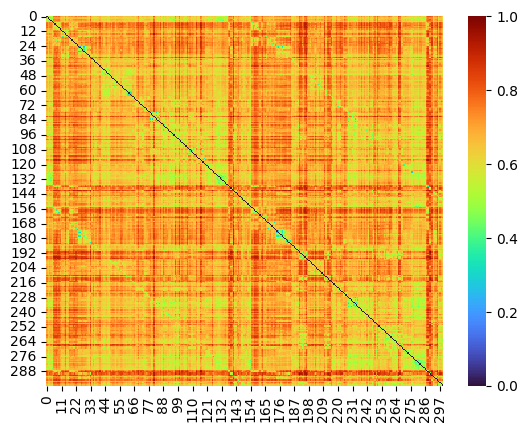

In [27]:
sns.heatmap(sdms[0], cmap='turbo')

### Compute RDMs

#### All participants at once

In [28]:
rdms_roi = np.full((cate_num, 23, stim_num*2, stim_num*2), np.nan)

In [ ]:
for cate in range(cate_num):
    for roi in tqdm(ROIs):
        roi_idx = list(ROIs).index(roi)
        preds = sub_pred_concat[:,cate,stim_num:,roi_idx]
        for i in range(stim_num*2):
            pred_i = preds[:,i]
            for j in range(stim_num*2):
                pred_j = preds[:,j]
                corr, p = stats.pearsonr(pred_i, pred_j)
                rdms_roi[cate,roi_idx,i,j] = 1 - corr

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

In [16]:
print(rdms_roi.shape)
print(np.isnan(rdms_roi).sum())
print(rdms_roi[0,0,:4,:4])

(4, 23, 400, 400)
0
[[0.00000000e+00 1.79995053e-01 2.99240861e-01 8.81795033e-02]
 [1.79995053e-01 1.11022302e-16 5.02448585e-01 3.47113392e-01]
 [2.99240861e-01 5.02448585e-01 1.11022302e-16 2.69870518e-01]
 [8.81795033e-02 3.47113392e-01 2.69870518e-01 1.11022302e-16]]


In [17]:
np.save("data/MVPA/paired_category_v2_thr04_image_ROI_RDMs.npy", rdms_roi)

<Axes: >

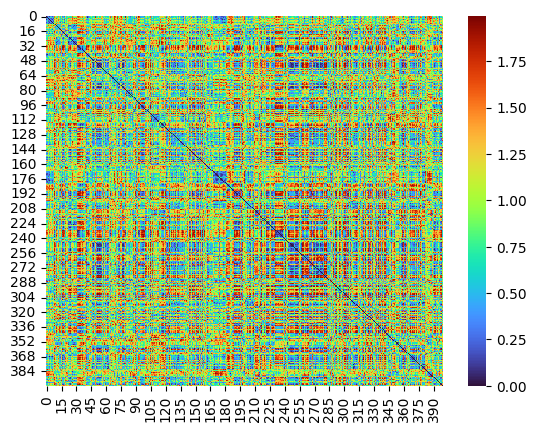

In [18]:
sns.heatmap(rdms_roi[0][0], cmap='turbo')

#### Averaging participants

In [ ]:
# Function to calculate RSA matrices using Pearson correlation
def compute_rsa_matrix(data):
   """ Compute the RSA matrix for one participant using Pearson correlation """
   num_images = data.shape[0]
   rsa_matrix = np.zeros((num_images, num_images))
   for i in range(num_images):
       for j in range(i + 1, num_images):
           # Compute Pearson correlation and take 1 - r to reflect dissimilarity
           r, _ = pearsonr(data[i], data[j])
           rsa_matrix[i, j] = rsa_matrix[j, i] = 1 - r
   return rsa_matrix

In [ ]:
highs = sub_pred_concat[:,100:200,:]

In [ ]:
# Compute RSA matrices for all participants
rsa_matrices = np.array([compute_rsa_matrix(sub_pred_concat[subj]) for subj in range(8)])

In [ ]:


# Analyze differences between the first image in each pair and the second
first_images = rsa_matrices[:, ::2, ::2]  # Selecting even indices for both rows and columns
second_images = rsa_matrices[:, 1::2, 1::2]  # Selecting odd indices for both rows and columns

# Average RSA matrices across participants for first and second images
avg_first_images = np.mean(first_images, axis=0)
avg_second_images = np.mean(second_images, axis=0)

# Statistical test to see if there's a significant difference in the RSA matrices
mask = np.triu_indices_from(avg_first_images, k=1)
t_stat, p_values = ttest_rel(first_images[:, mask[0], mask[1]],
                            second_images[:, mask[0], mask[1]],
                            axis=0)

# Show results
print("T-statistic:", t_stat)
print("P-values:", p_values)

# Plotting the average RSA matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(avg_first_images, ax=ax[0], cmap='viridis', square=True)
ax[0].set_title('Average RSA for First Images')
sns.heatmap(avg_second_images, ax=ax[1], cmap='viridis', square=True)
ax[1].set_title('Average RSA for Second Images')
plt.show()

### Analysis

In [6]:
mvpa_dir = "data/MVPA/"

In [7]:
sdms = np.load(mvpa_dir+"paired_new_category_image_SDMs.npy")
rdms_roi = np.load(mvpa_dir+"paired_new_category_ROI_RDMs.npy")

print(sdms.shape, rdms_roi.shape)

(5, 200, 200) (5, 23, 200, 200)


In [8]:
# tst = np.array([[1,2,3],[4,5,6],[7,8,9]])
# tst_idx = np.tril_indices_from(tst, -1)
# print(np.tril(tst,-1))
# print(tst[tst_idx])

In [9]:
spearmans_RSA = np.zeros((5, 23))
for cate in trange(5):
    for roi_idx in range(23):
        rdms_roi_indices = np.triu_indices_from(rdms_roi[cate][roi_idx], 1)
        sdms_indices = np.triu_indices_from(sdms[cate], 1)
        rdms_roi_triu = rdms_roi[cate][roi_idx][rdms_roi_indices]
        sdms_triu = sdms[cate][sdms_indices]
        
        r, p = stats.spearmanr(rdms_roi_triu, sdms_triu)
        spearmans_RSA[cate,roi_idx] = r

  0%|          | 0/5 [00:00<?, ?it/s]

In [10]:
for cate in trange(5):
    print(np.array(ROIs)[spearmans_RSA[cate].argsort()[::-1][0:5]])
    print([round(e,2) for e in spearmans_RSA[cate]])

  0%|          | 0/5 [00:00<?, ?it/s]

['V3d' 'V2d' 'V1d' 'FBA1' 'OFA']
[0.18, 0.08, 0.13, 0.13, 0.14, 0.12, 0.19, 0.13, 0.08, 0.15, 0.15, 0.17, 0.16, 0.2, 0.14, 0.2, 0.12, 0.23, 0.13, 0.08, 0.08, 0.05, 0.13]
['aTLfaces' 'FBA1' 'R-amygdala' 'mTLfaces' 'V3v']
[0.18, 0.24, 0.28, 0.34, 0.36, 0.29, 0.35, 0.31, 0.24, 0.3, 0.21, 0.3, 0.2, 0.26, 0.24, 0.25, 0.33, 0.21, 0.25, 0.16, 0.3, 0.13, 0.34]
['V1v' 'hV4' 'V2v' 'V1d' 'RSC']
[0.1, 0.14, 0.1, 0.04, 0.05, 0.08, 0.17, 0.16, -0.0, 0.13, 0.19, 0.21, 0.28, 0.22, 0.23, 0.15, 0.12, 0.15, 0.24, 0.12, 0.07, 0.1, 0.09]
['V1d' 'V1v' 'V2v' 'V2d' 'V3v']
[0.13, 0.08, 0.07, 0.07, 0.11, 0.1, 0.14, 0.17, 0.09, 0.16, 0.17, 0.2, 0.31, 0.32, 0.29, 0.24, 0.22, 0.21, 0.11, 0.13, 0.18, 0.08, 0.15]
['V1v' 'V2v' 'V1d' 'hV4' 'PPA']
[0.23, 0.21, 0.13, 0.16, 0.13, 0.17, 0.25, 0.2, 0.06, 0.17, 0.25, 0.17, 0.45, 0.35, 0.41, 0.22, 0.25, 0.25, 0.34, 0.18, 0.16, 0.14, 0.08]


In [21]:
transformed_RSA = np.zeros((5, 23))
for cate in trange(5):
    for roi_idx in range(23):
        rdms_roi_indices = np.triu_indices_from(rdms_roi[cate][roi_idx], 1)
        sdms_indices = np.triu_indices_from(sdms[cate], 1)
        rdms_roi_triu = rdms_roi[cate][roi_idx][rdms_roi_indices]
        sdms_triu = sdms[cate][sdms_indices]
        
        corr, p = stats.spearmanr(rdms_roi_triu, sdms_triu)
        transformed_RSA[cate,roi_idx] = 0.5 * np.log((1 + corr) / (1 - corr))

  0%|          | 0/5 [00:00<?, ?it/s]

In [22]:
for cate in trange(5):
    print(np.array(ROIs)[transformed_RSA[cate].argsort()[::-1][0:5]])
    print([round(e,2) for e in transformed_RSA[cate]])

  0%|          | 0/5 [00:00<?, ?it/s]

['V3d' 'V2d' 'V1d' 'FBA1' 'OFA']
[0.18, 0.08, 0.13, 0.13, 0.14, 0.12, 0.2, 0.13, 0.08, 0.15, 0.16, 0.17, 0.16, 0.2, 0.15, 0.21, 0.12, 0.23, 0.13, 0.08, 0.08, 0.05, 0.13]
['aTLfaces' 'FBA1' 'R-amygdala' 'mTLfaces' 'V3v']
[0.18, 0.25, 0.29, 0.35, 0.38, 0.3, 0.37, 0.32, 0.25, 0.31, 0.21, 0.31, 0.2, 0.26, 0.25, 0.25, 0.35, 0.21, 0.25, 0.16, 0.31, 0.13, 0.35]
['V1v' 'hV4' 'V2v' 'V1d' 'RSC']
[0.1, 0.14, 0.1, 0.04, 0.05, 0.08, 0.17, 0.16, -0.0, 0.13, 0.19, 0.21, 0.28, 0.22, 0.23, 0.15, 0.12, 0.15, 0.24, 0.12, 0.07, 0.1, 0.09]
['V1d' 'V1v' 'V2v' 'V2d' 'V3v']
[0.13, 0.08, 0.07, 0.07, 0.11, 0.1, 0.14, 0.17, 0.09, 0.16, 0.17, 0.2, 0.32, 0.33, 0.3, 0.24, 0.23, 0.21, 0.11, 0.13, 0.18, 0.08, 0.15]
['V1v' 'V2v' 'V1d' 'hV4' 'PPA']
[0.23, 0.21, 0.14, 0.16, 0.13, 0.17, 0.26, 0.21, 0.06, 0.17, 0.26, 0.18, 0.48, 0.37, 0.44, 0.22, 0.26, 0.26, 0.35, 0.18, 0.17, 0.14, 0.08]


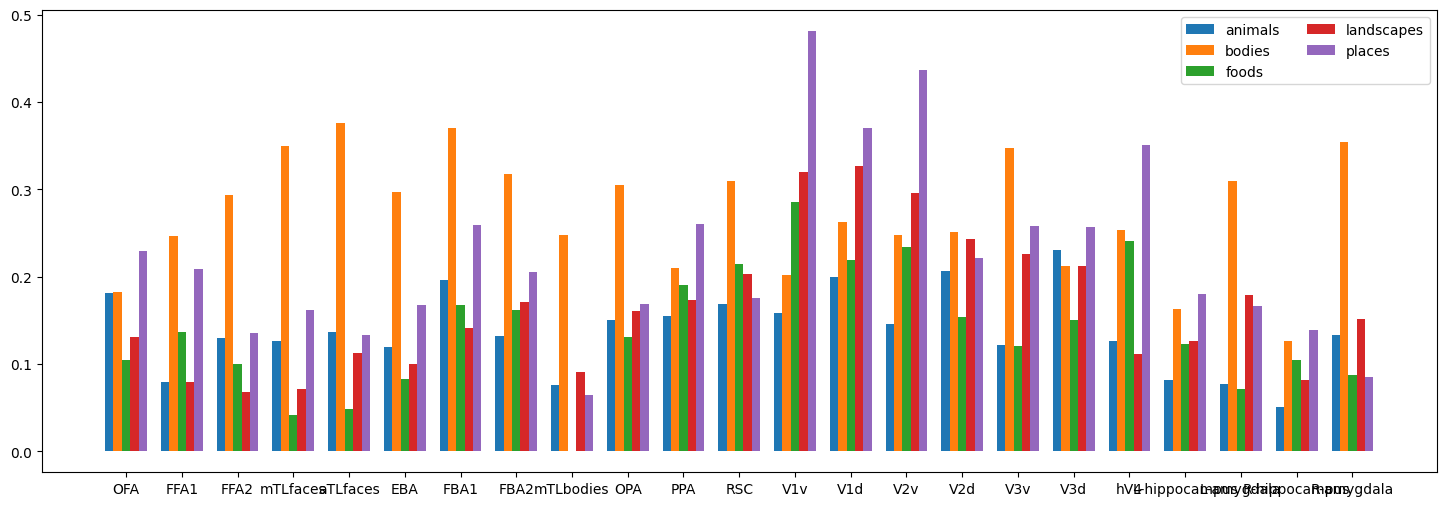

In [35]:
plt.figure(figsize=(18, 6))
width = 0.15
X = np.arange(len(ROIs))
for cate in range(5):
    plt.bar(X+(width*cate), transformed_RSA[cate], width, label=categories[cate])

plt.xticks(ticks=X+0.3, labels=ROIs)
plt.legend(ncol=2)
plt.show()

In [13]:
from sklearn.manifold import MDS

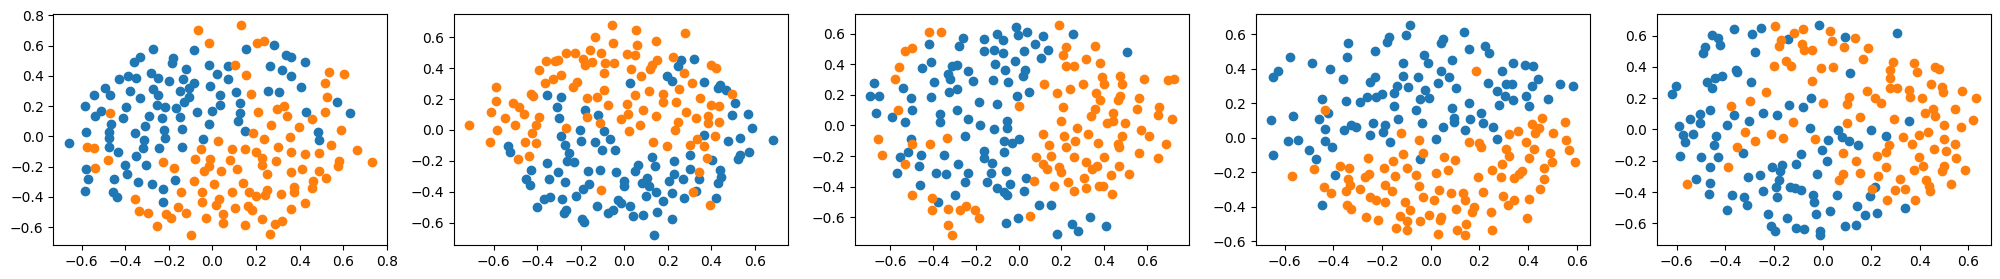

In [16]:
# def imscatter(x, y, image_list, ax=None, zoom=1, c="black"):
#     x, y = np.atleast_1d(x, y)
#     artists = []
#     for x0, y0, image in zip(x, y, image_list):
#         im = OffsetImage(image, zoom=zoom)
#         ab = AnnotationBbox(
#             im, (x0, y0), xycoords="data", frameon=True, bboxprops=dict(edgecolor=c)
#         )
#         artists.append(ax.add_artist(ab))
#     ax.update_datalim(np.column_stack([x, y]))
#     ax.autoscale()
#     return artists

fig, axes = plt.subplots(1, 5, figsize=(25, 3))
for i, ax in enumerate(axes):
    embedding = MDS(n_components=2, dissimilarity="precomputed", normalized_stress="auto")
    mds = embedding.fit_transform(sdms[i])
 
    ax.scatter(mds[:100, 0], mds[:100, 1])
    ax.scatter(mds[100:, 0], mds[100:, 1])

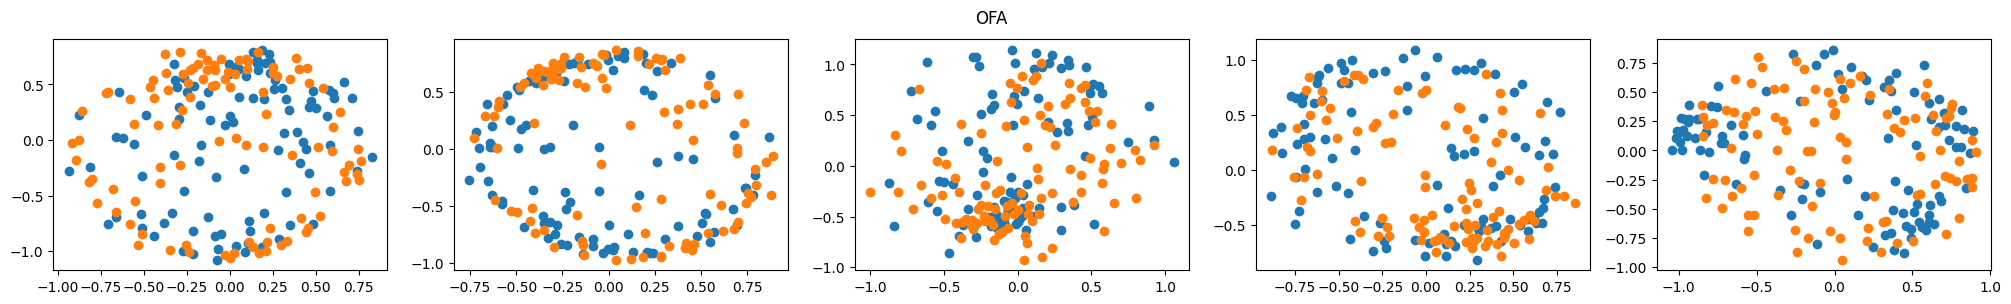

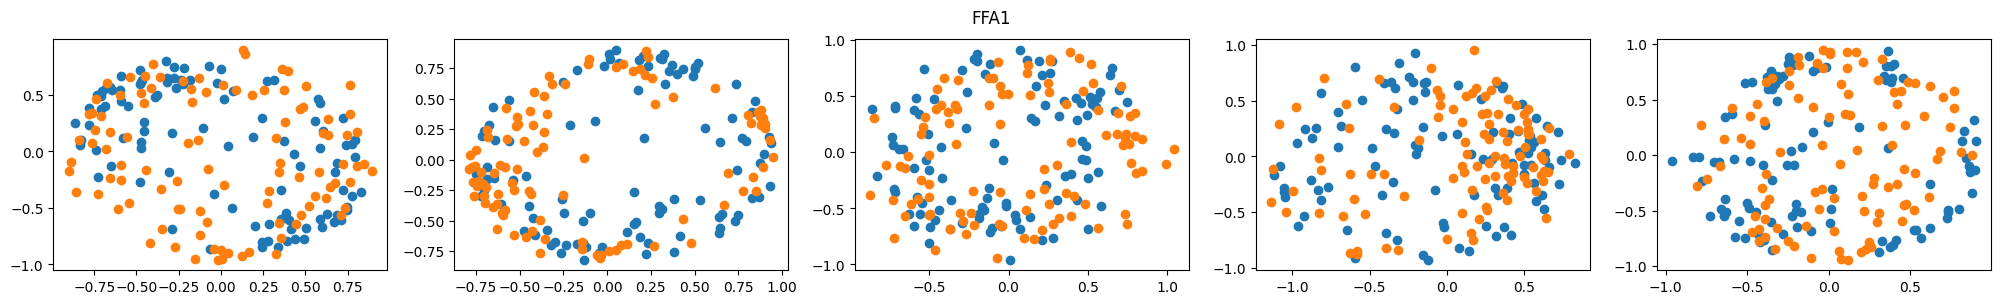

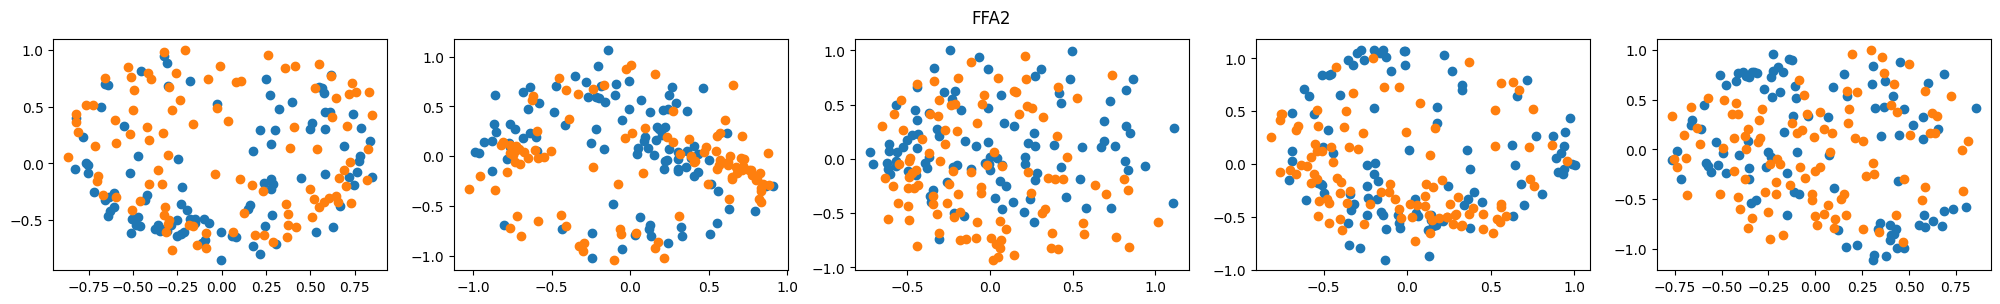

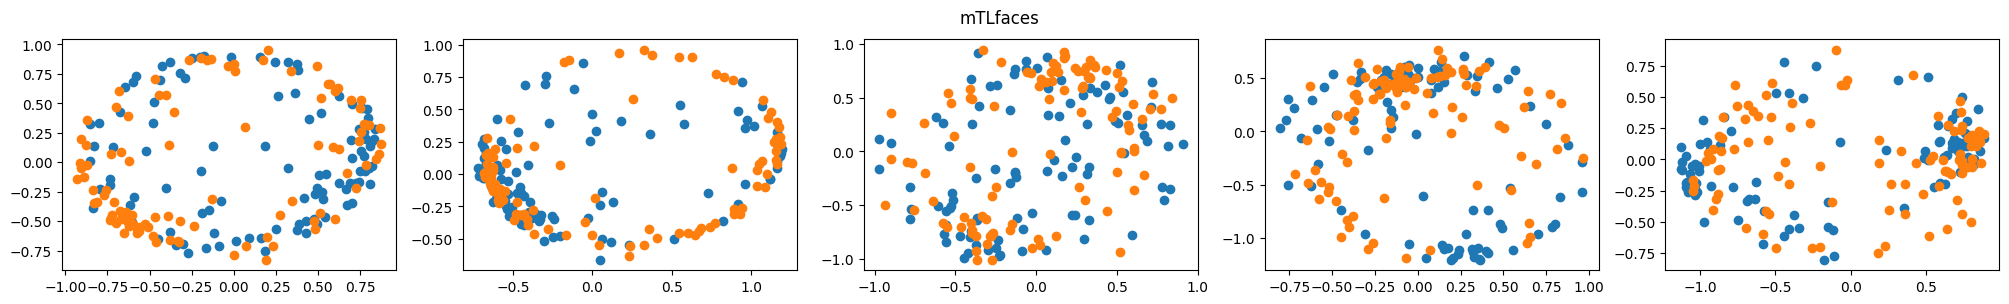

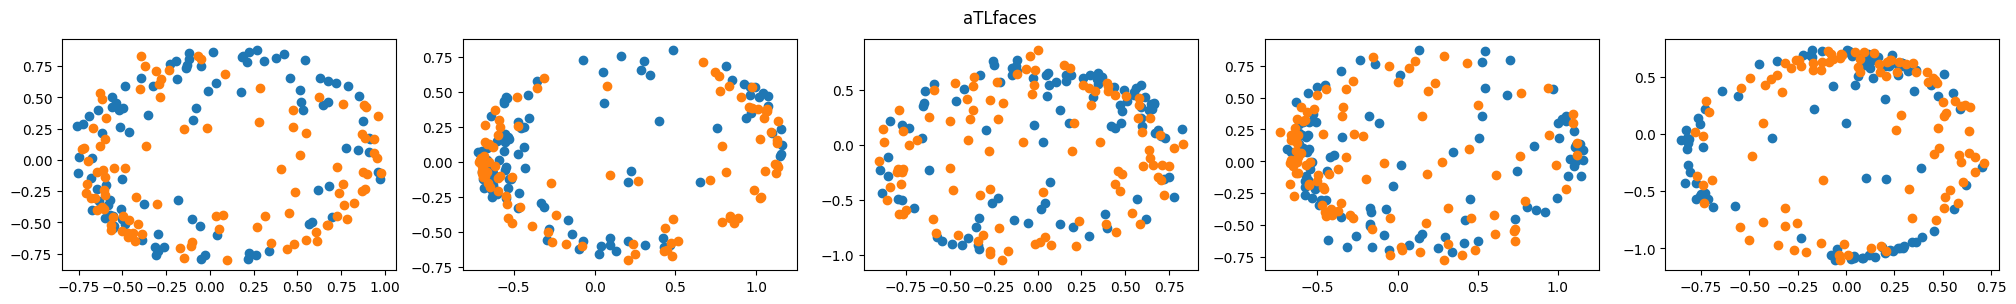

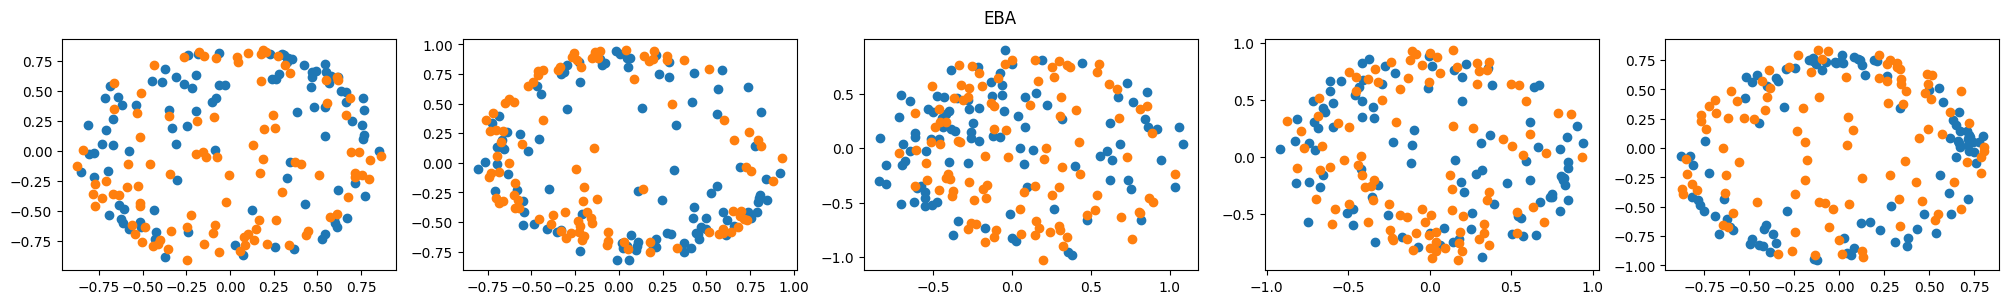

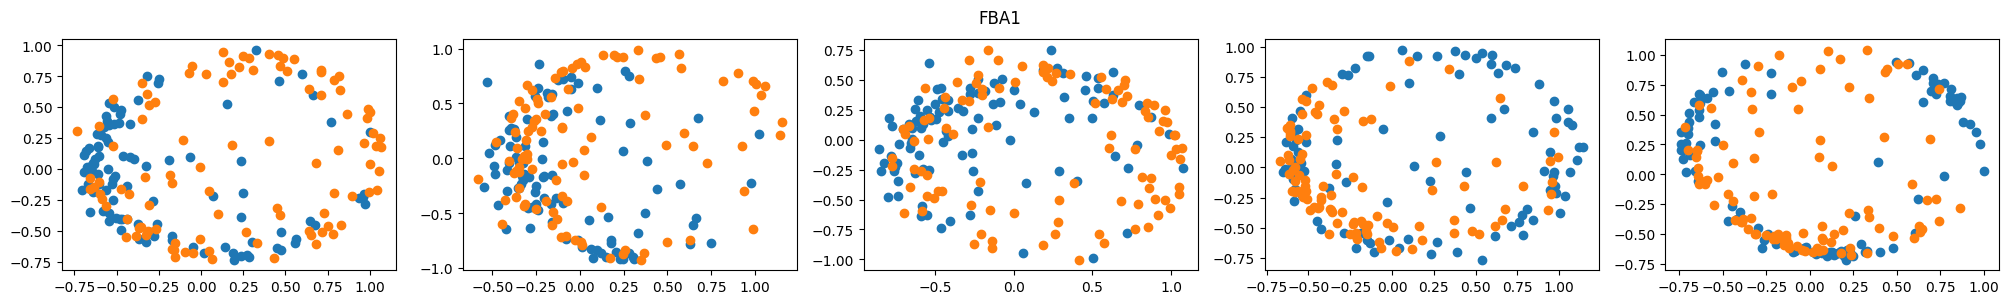

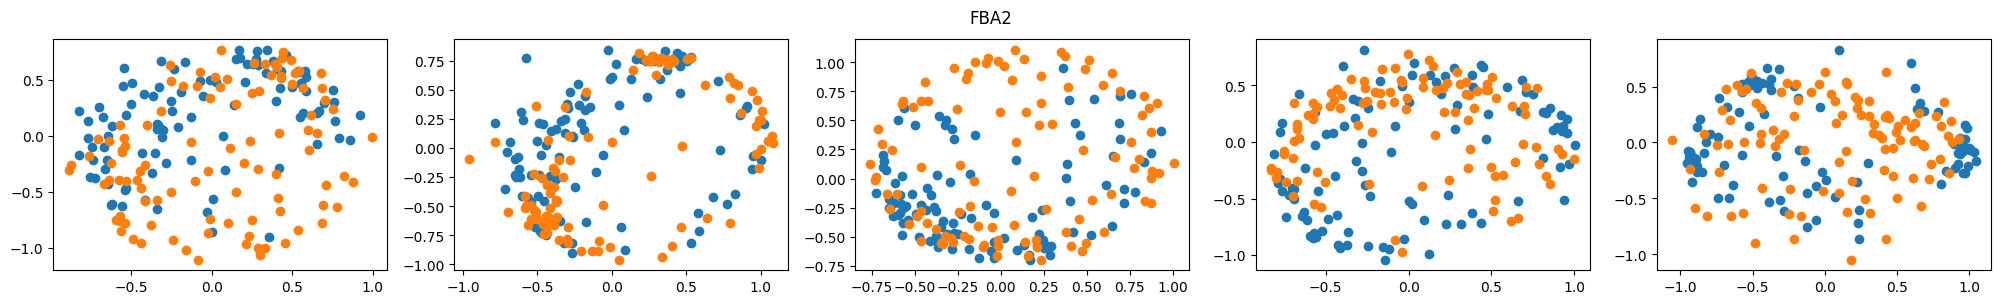

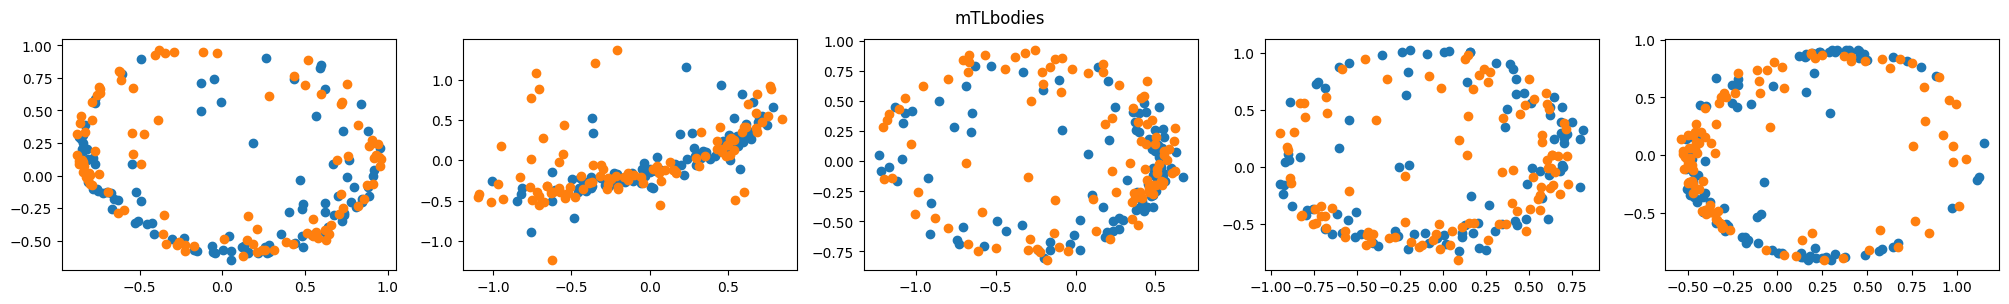

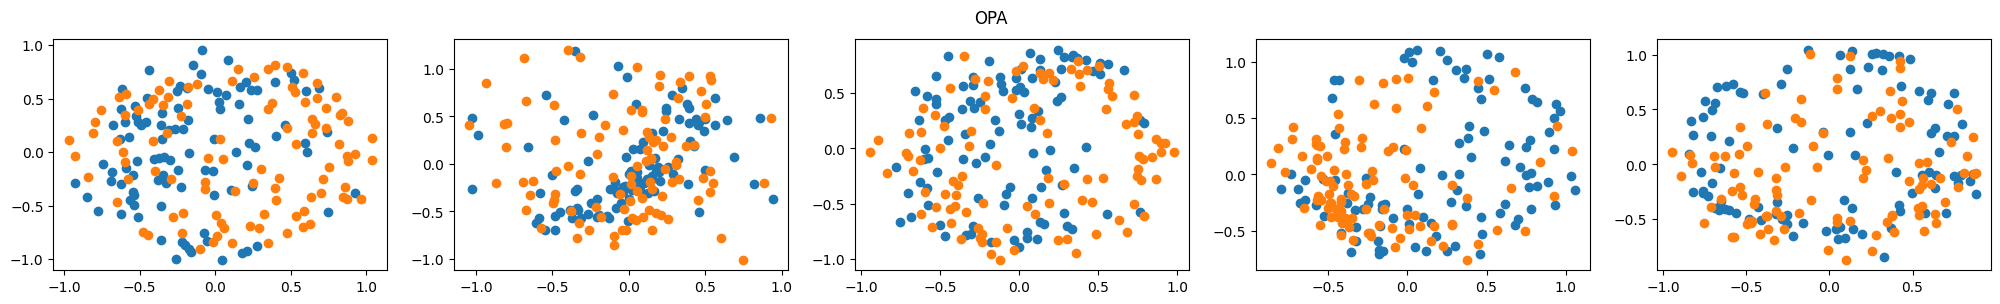

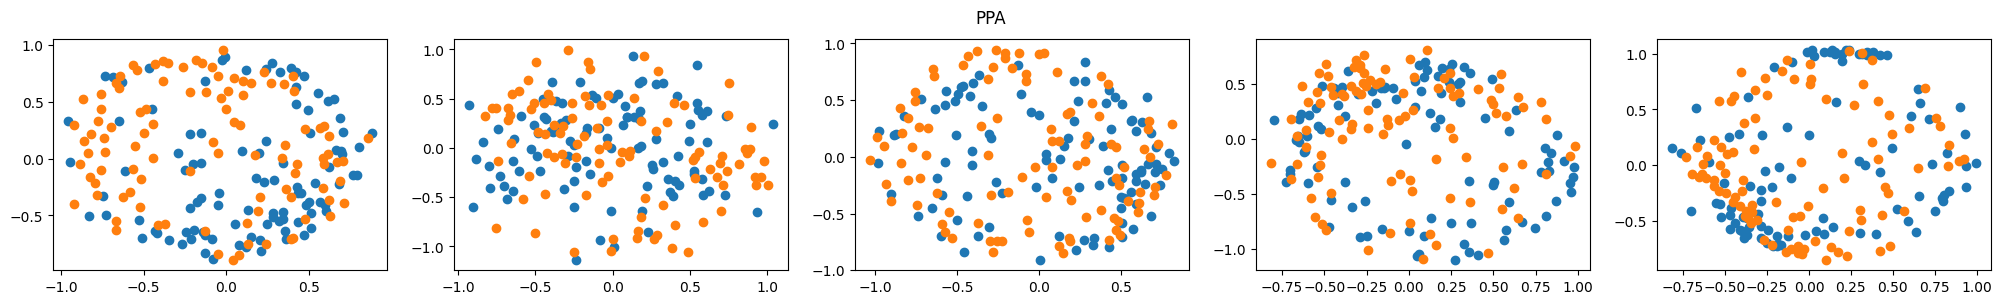

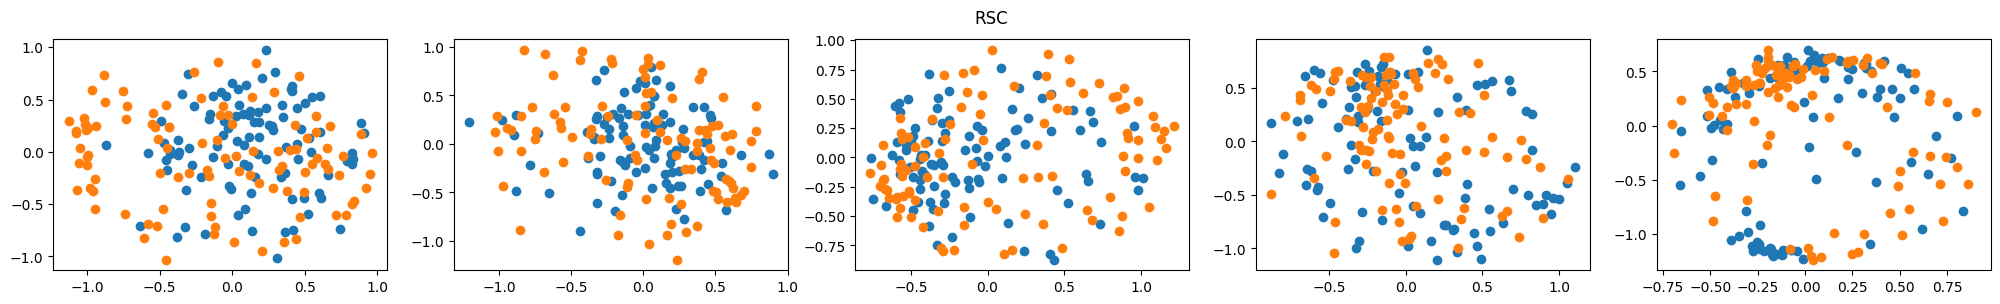

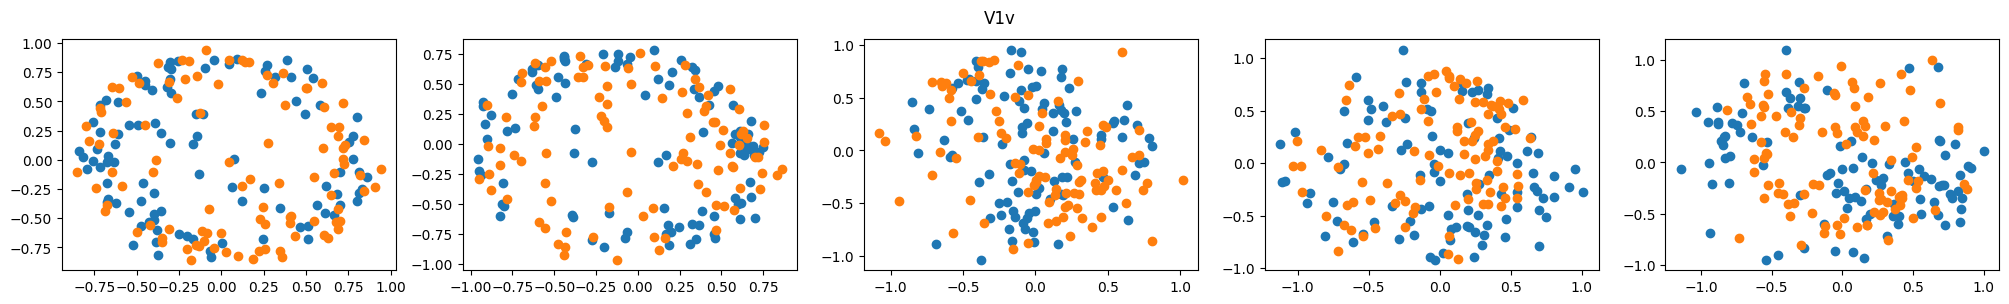

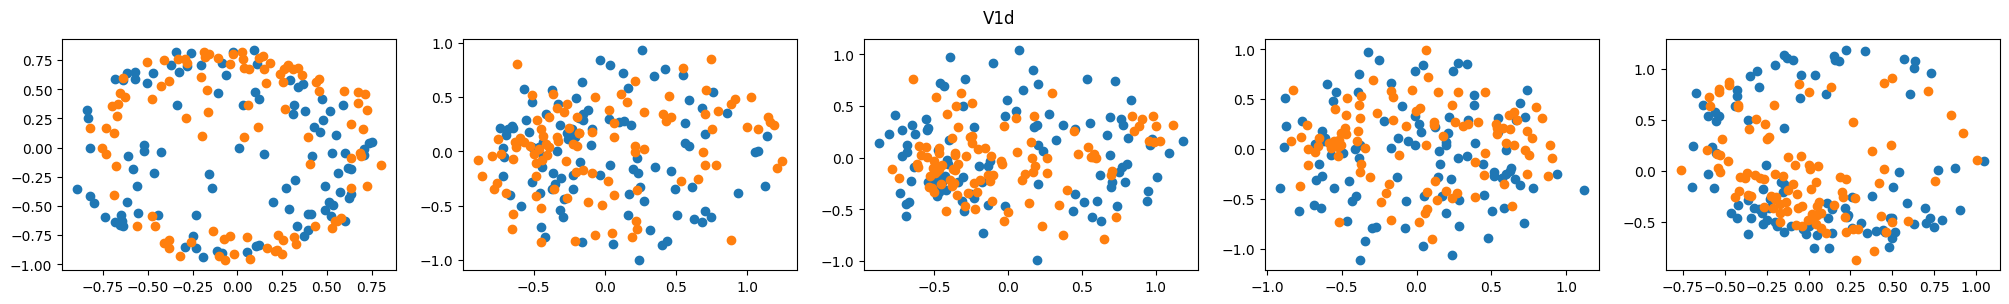

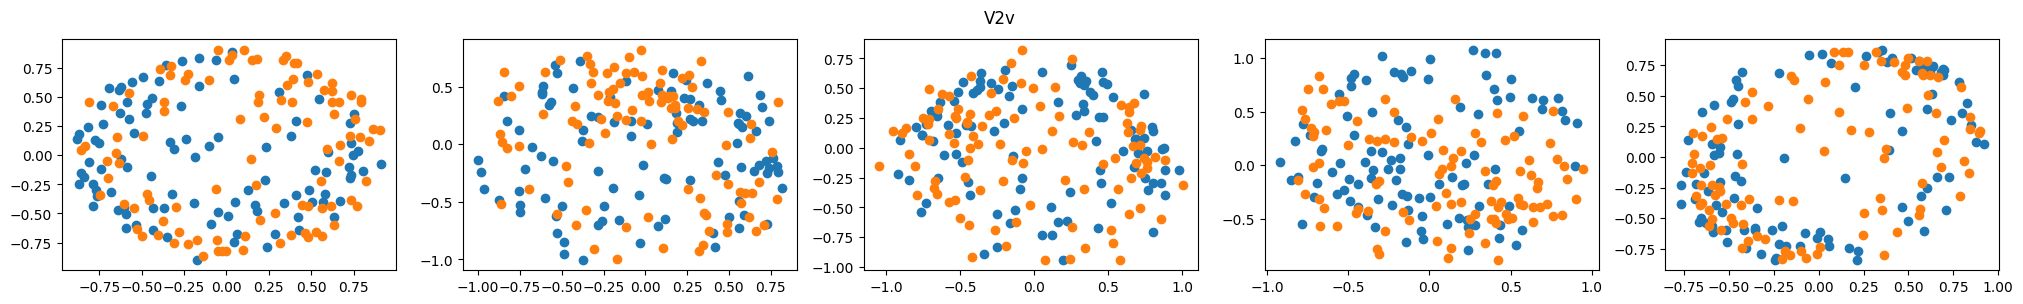

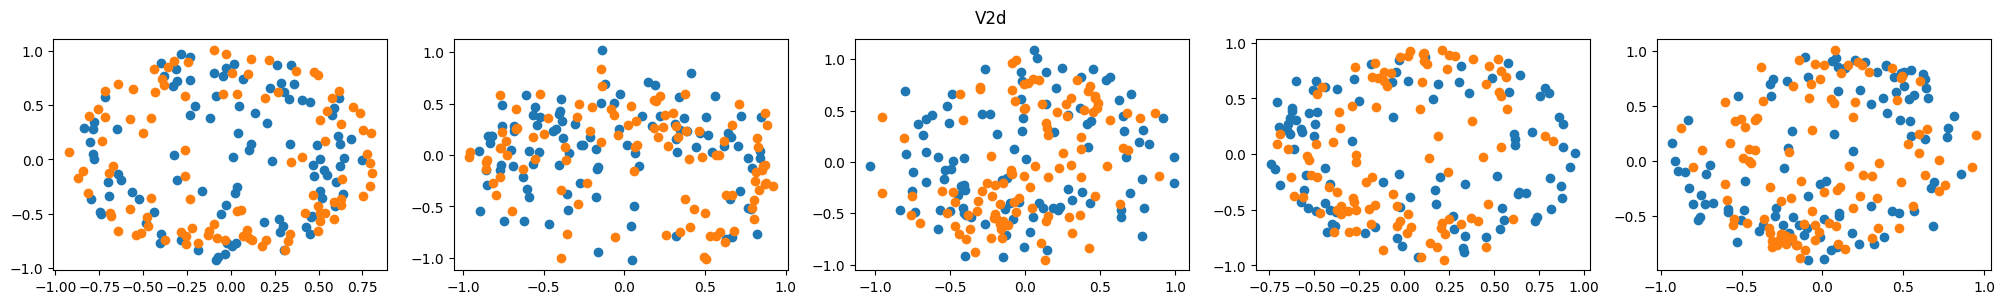

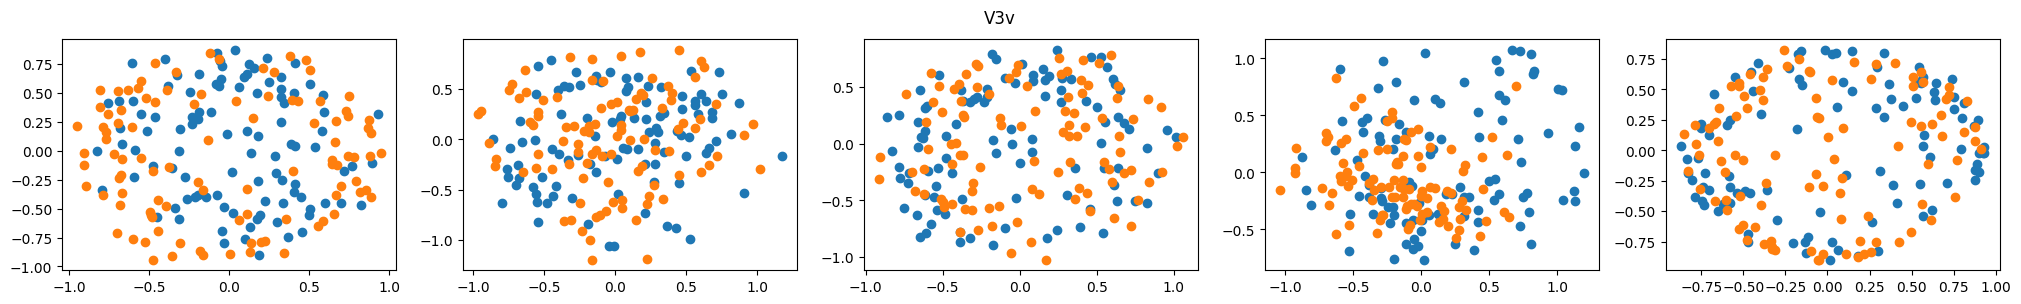

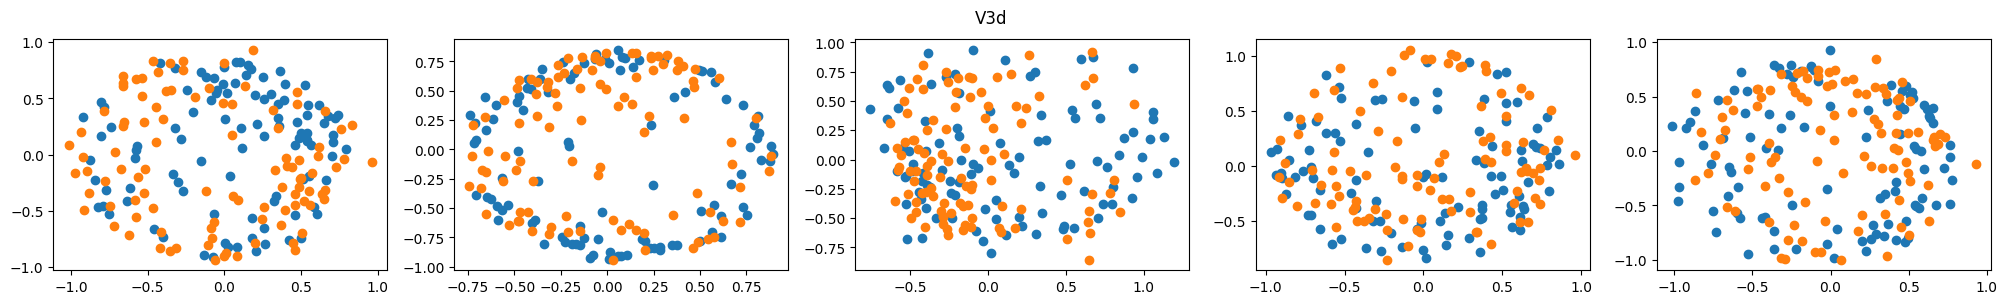

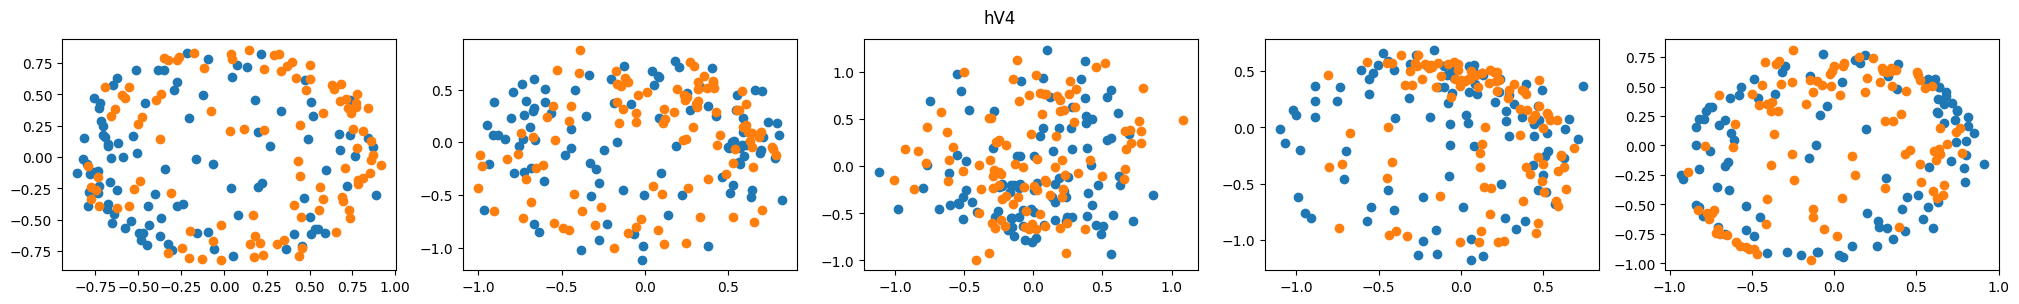

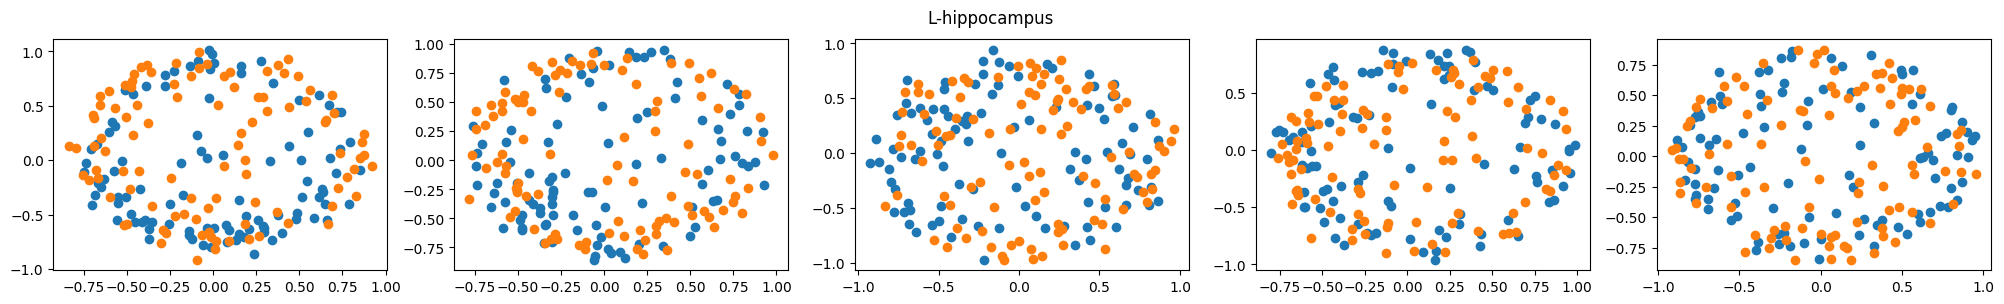

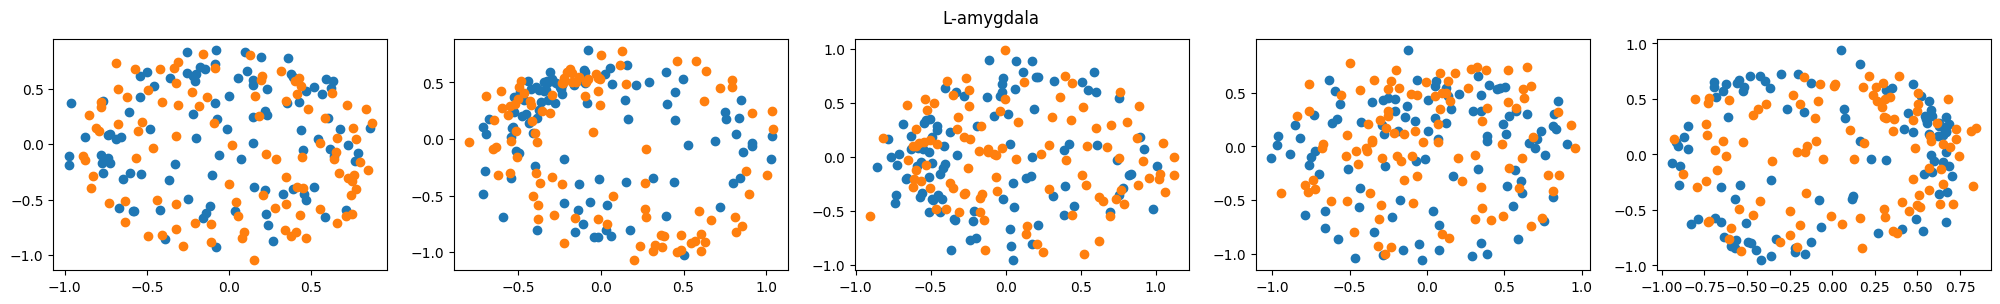

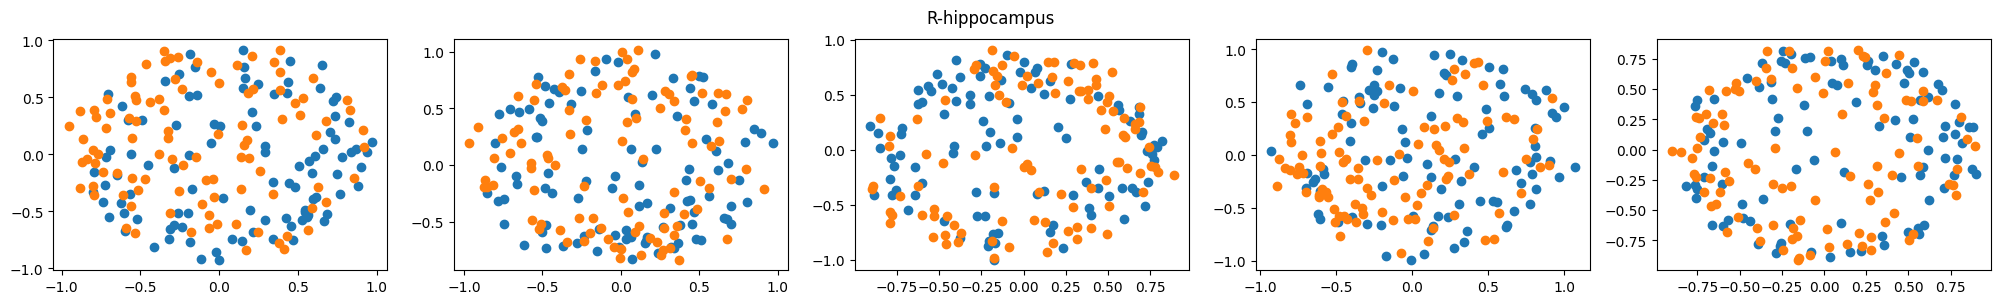

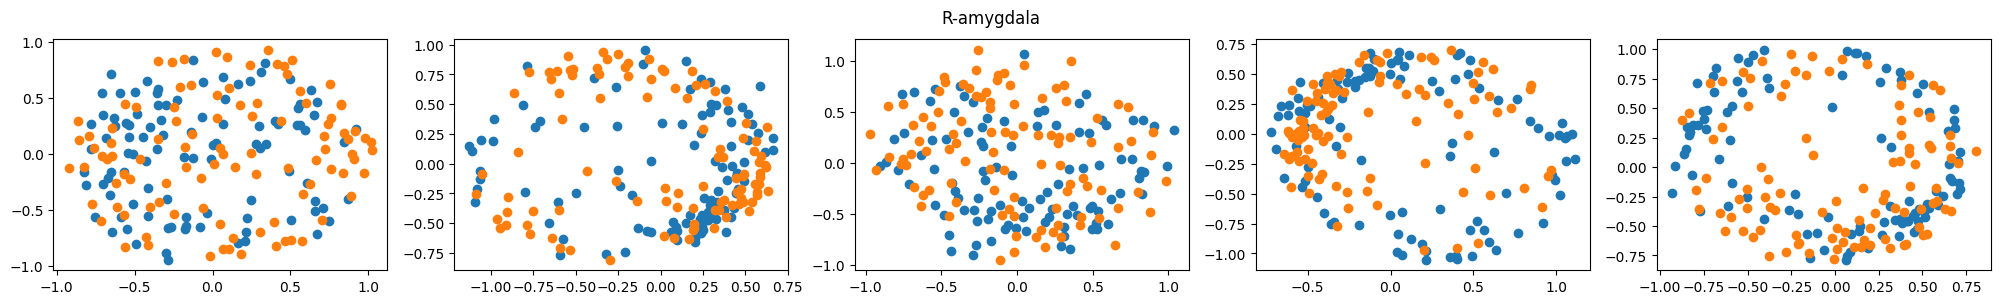

In [20]:
for roi in range(23):
    fig, axes = plt.subplots(1, 5, figsize=(25, 3))
    for i, ax in enumerate(axes):
        embedding = MDS(n_components=2, dissimilarity="precomputed", normalized_stress="auto")
        mds = embedding.fit_transform(rdms_roi[i, roi])
     
        ax.scatter(mds[:100, 0], mds[:100, 1])
        ax.scatter(mds[100:, 0], mds[100:, 1])
    plt.suptitle(ROIs[roi])
    plt.show()

### Dpr

In [45]:
# for cate in range(4):
#     for roi in tqdm(ROIs):
#         roi_idx = list(ROIs).index(roi)
#         origs = sub_pred_concat[:,cate,:100,roi_idx]
#         for i in range(100):
#             orig_i = origs[:,i]
#             for j in range(100):
#                 orig_j = origs[:,j]
#                 corr, p = stats.pearsonr(orig_i, orig_j)
#                 rdms_roi[cate,0,roi_idx,i,j] = 1 - corr

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

In [48]:
pearsons_dict = {}
spearmans_dict = {}
for cate in range(4):
    spearmans = []
    pearsons = []
    for roi in tqdm(ROIs):
        roi_idx = list(ROIs).index(roi)
        
        rdm_highs = rdms_roi[cate,1,roi_idx,:,:]
        rdm_lows = rdms_roi[cate,2,roi_idx,:,:]
        
        highs_indices = np.triu_indices_from(rdm_highs, k=1)
        lows_indices = np.triu_indices_from(rdm_lows, k=1)
        
        triu_highs = rdm_highs[highs_indices]
        triu_lows = rdm_lows[lows_indices]
    
        spearman_r, sparman_p = stats.spearmanr(triu_highs, triu_lows)
        spearmans.append(spearman_r)
        pearson_r, pearson_p = stats.pearsonr(triu_highs, triu_lows)
        pearsons.append(pearson_r)
    
    pearsons_dict[cate] = pearsons
    spearmans_dict[cate] = spearmans

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

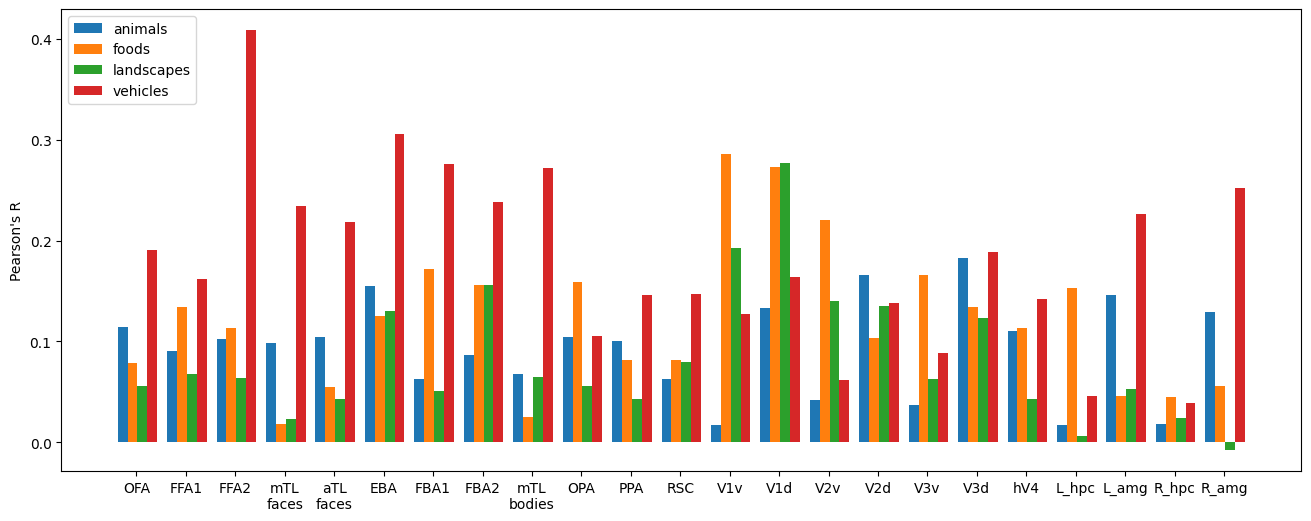

In [61]:
plt_dict = {
    "animals": pearsons_dict[0],
    "foods": pearsons_dict[1],
    "landscapes": pearsons_dict[2],
    "vehicles": pearsons_dict[3],
}

x = np.arange(23)  # the label locations
width = 0.2  # the width of the bars
multiplier = 0.6

fig, ax = plt.subplots(figsize=(16,6))

for attribute, measurement in plt_dict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel("Pearson's R")
ax.set_xticks(ticks=x+0.4, labels=ROIs_label)
ax.legend(loc='upper left', ncols=1)

plt.show()

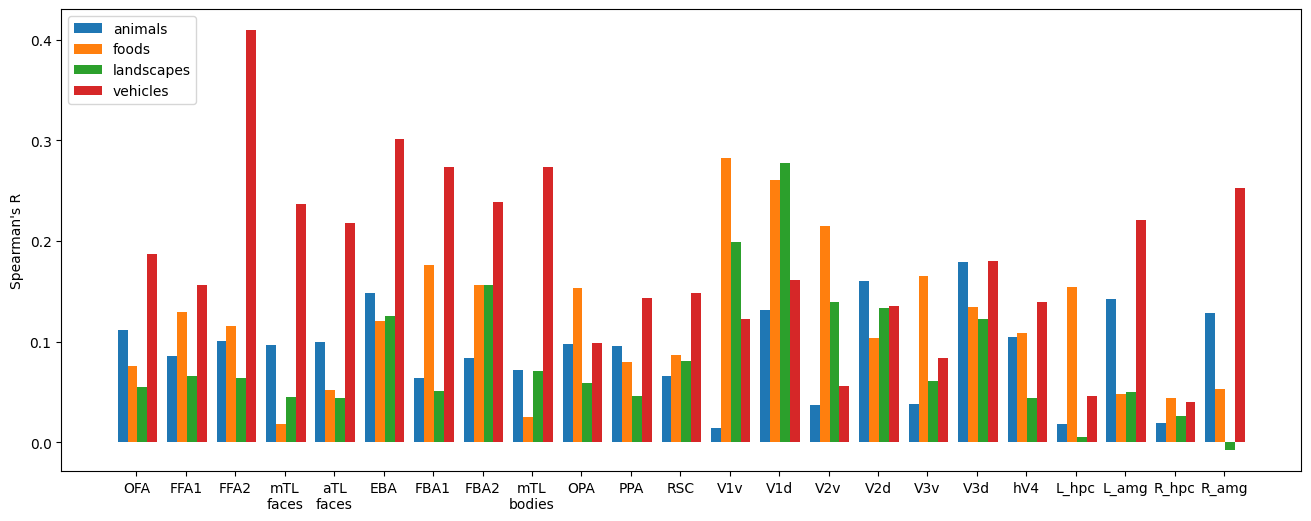

In [62]:
plt_dict = {
    "animals": spearmans_dict[0],
    "foods": spearmans_dict[1],
    "landscapes": spearmans_dict[2],
    "vehicles": spearmans_dict[3],
}

x = np.arange(23)  # the label locations
width = 0.2  # the width of the bars
multiplier = 0.6

fig, ax = plt.subplots(figsize=(16,6))

for attribute, measurement in plt_dict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel("Spearman's R")
ax.set_xticks(ticks=x+0.4, labels=ROIs_label)
ax.legend(loc='upper left', ncols=1)

plt.show()

## PCA

In [5]:
# Function to reduce dimensions by PCA
def reduce_dimensions_pca(data, slices):
    reduced_data = np.full((5, 4, 300, 2), np.nan)
    scaler = MinMaxScaler()
    for i, (key, indices) in enumerate(slices.items()):
        for j in range(4):
            sliced_data = data[j,:,indices]
            sliced_data = scaler.fit_transform(sliced_data)
            pca = PCA(n_components=2)
            reduced_data[i,j,:,:] = pca.fit_transform(sliced_data)
    return reduced_data

# Defining the feature categories
ROI_categories = {
    'face': slice(0, 5),
    'body': slice(5, 9),
    'place': slice(9, 12),
    'early_visual': slice(12, 19),
    'memory': slice(19, 23)
}

In [6]:
pred_pca = reduce_dimensions_pca(pred_concat, ROI_categories)
print("Reduced Data by PCA:", pred_pca.shape)

Reduced Data by PCA: (5, 4, 300, 2)


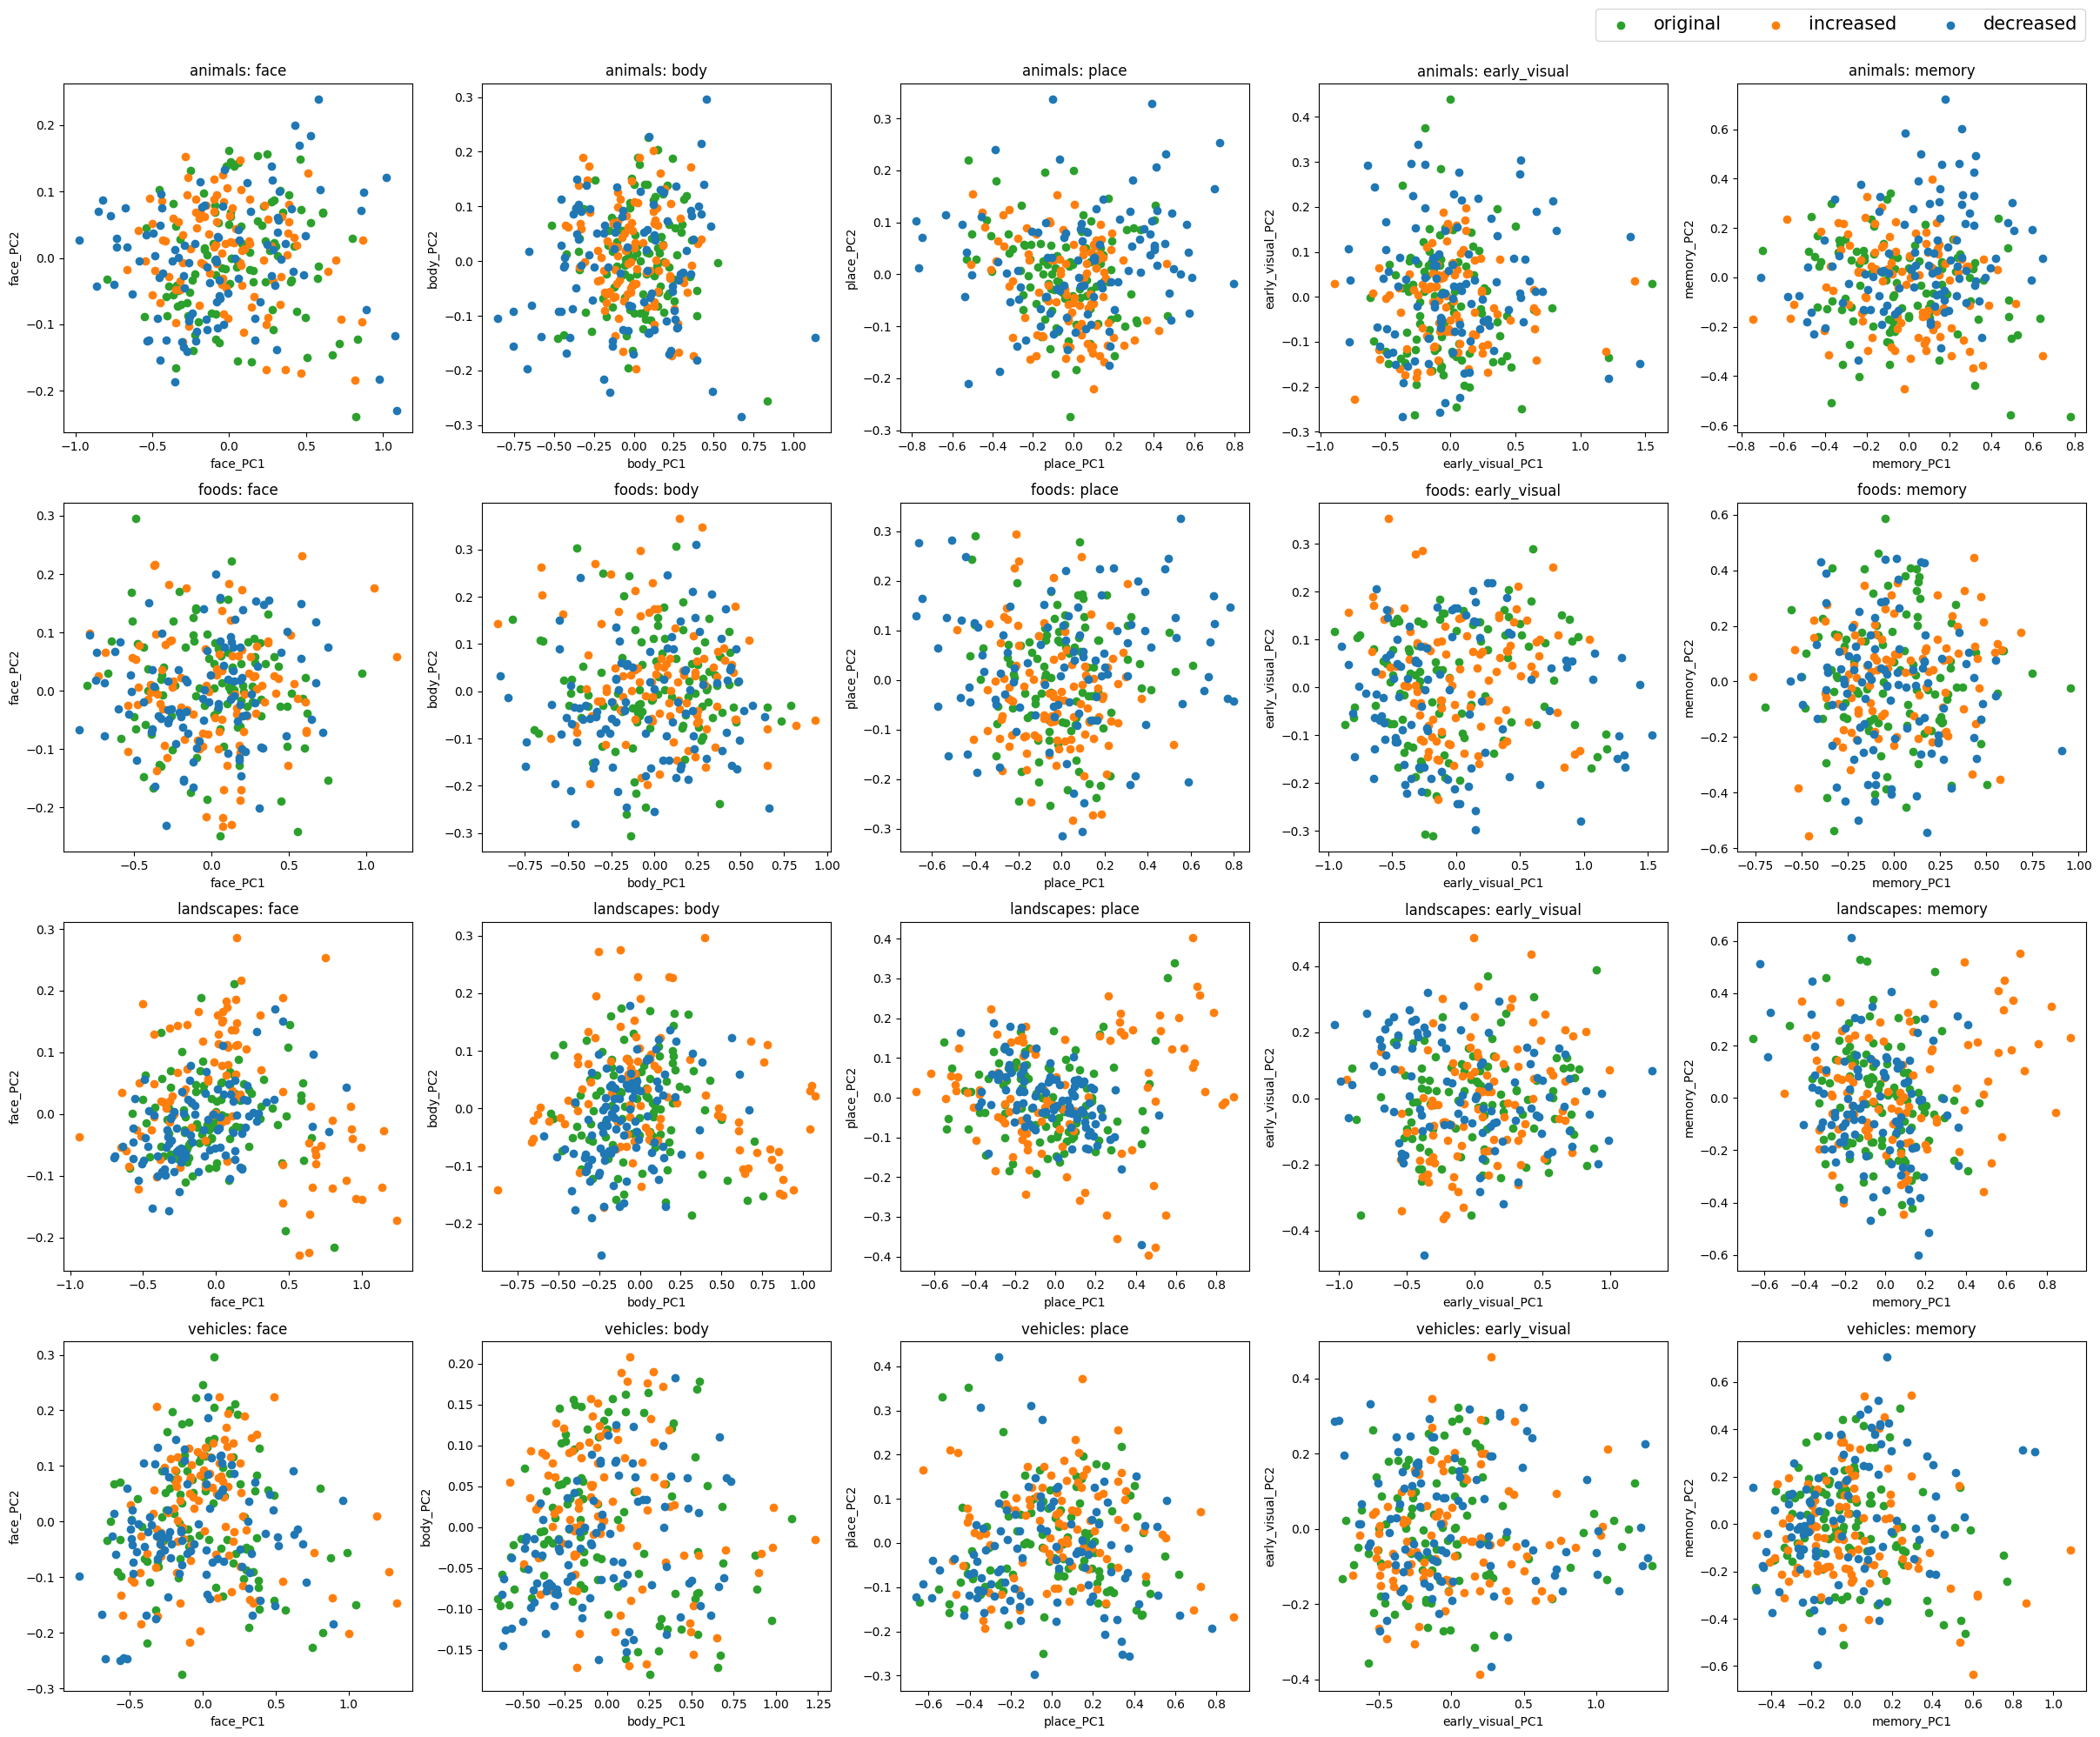

In [7]:
plt.figure(figsize=(30, 24))
for i in range(4):
    for j, roi in enumerate(ROI_categories.keys()):
        ax = plt.subplot2grid((4,5), (i, j))
        scatt0 = ax.scatter(
            pred_pca[j, i, :100, 0], pred_pca[j, i, :100, 1],
            color="tab:green", label="original"
        )
        scatt1 = ax.scatter(
            pred_pca[j, i, 100:200, 0], pred_pca[j, i, 100:200, 1],
            color="tab:orange", label="increased"
        )
        scatt2 = ax.scatter(
            pred_pca[j, i, 200:, 0], pred_pca[j, i, 200:, 1],
            color="tab:blue", label="decreased"
        )
        
        ax.set_xlabel(f"{roi}_PC1")
        ax.set_ylabel(f"{roi}_PC2")
        plt.title(f"{categories[i]}: {roi}")
        # plt.legend()

plt.figlegend(handles=[scatt0, scatt1, scatt2], ncols=3, loc="upper right", fontsize=15, bbox_to_anchor=(0.903, 0.92))
plt.show()

## Scatter plots

In [8]:
ROIs_pca = list(ROI_categories.keys())
comb = combinations(list(range(len(ROIs_pca))), 2)

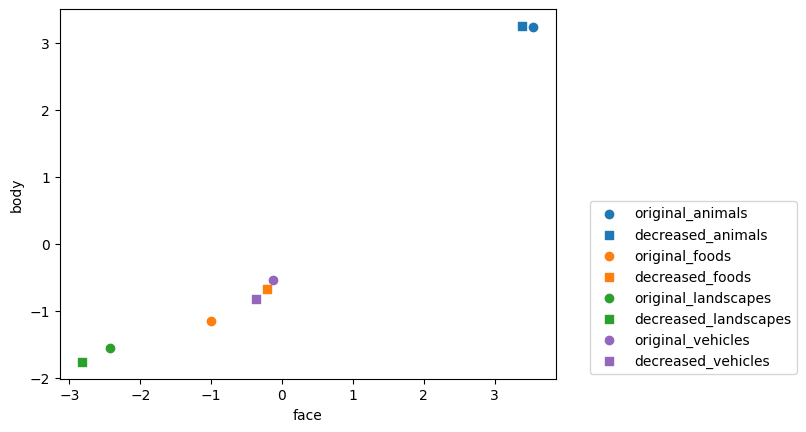

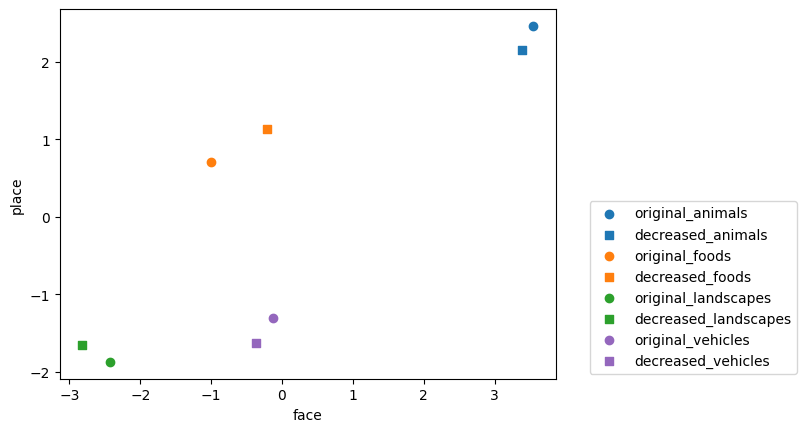

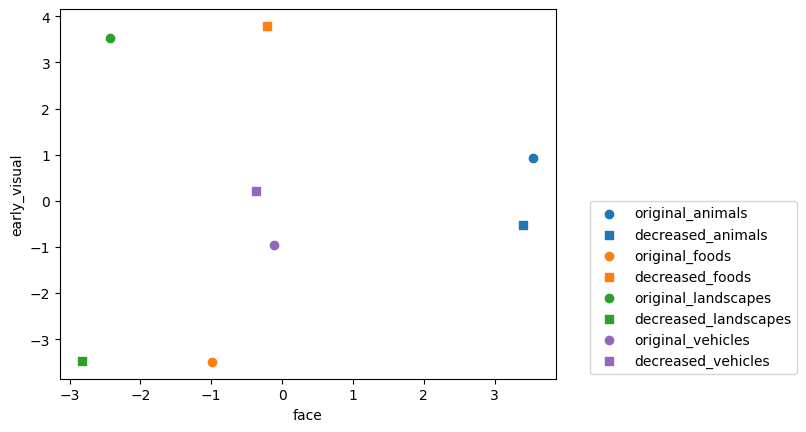

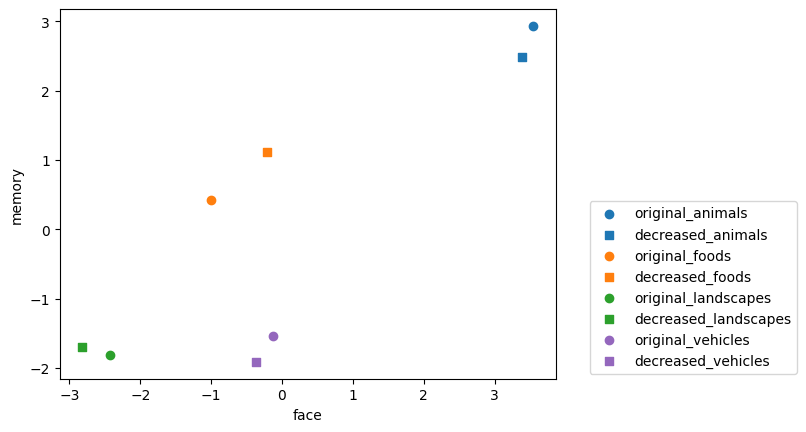

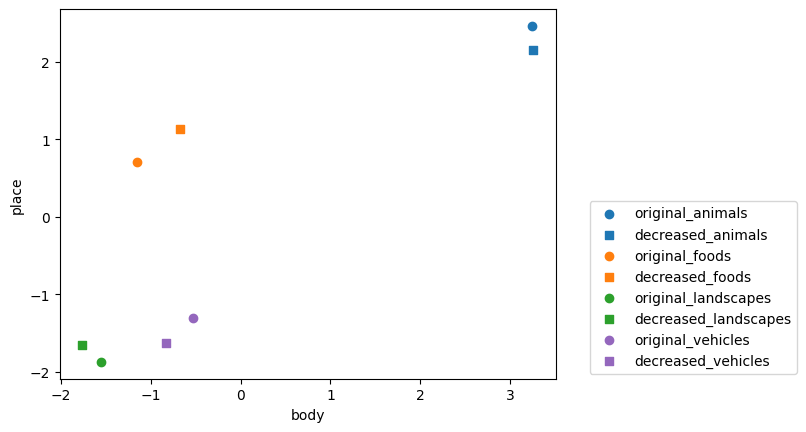

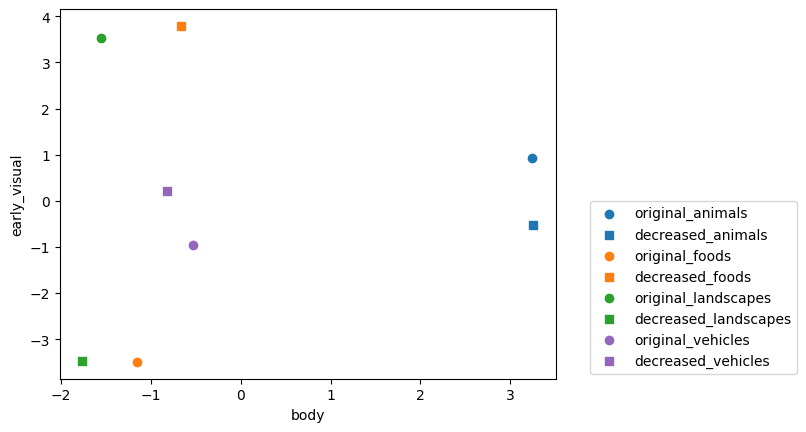

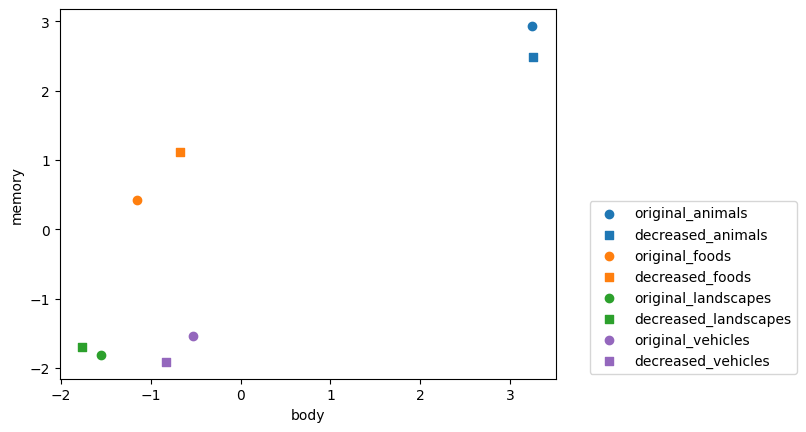

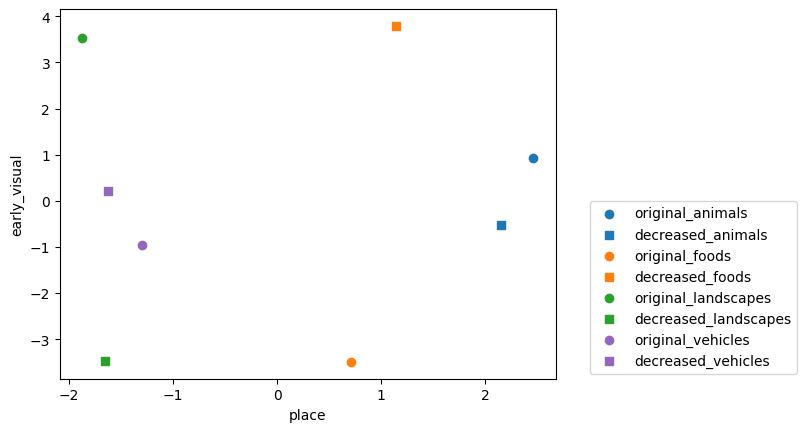

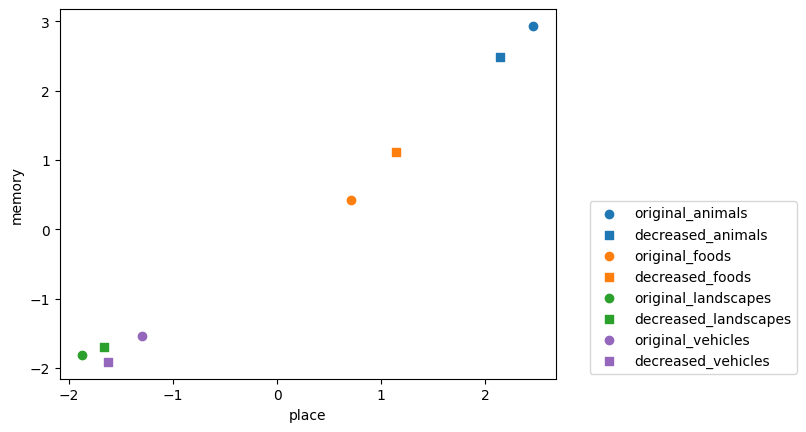

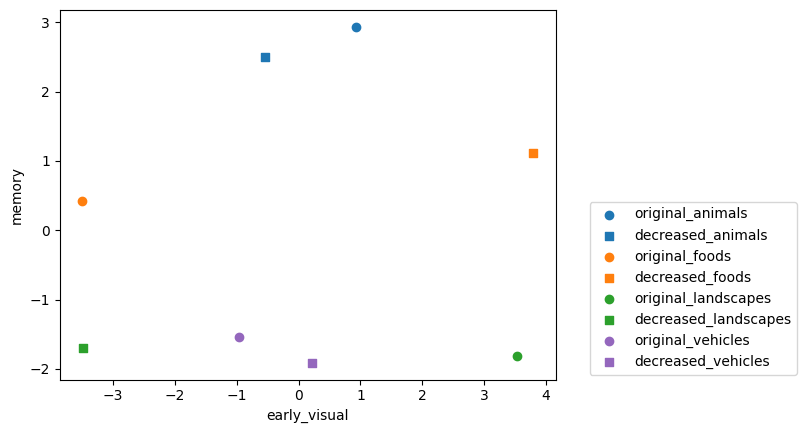

In [9]:
for idx0, idx1 in comb:
    # fig = plt.figure()
    
    for idx, c in zip(list(range(4)), ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']):
        plt.scatter(
            pred_pca[idx,idx0], pred_pca[idx,idx1],
            color=c, label=f"original_{categories[idx]}", marker='o'
        )
        plt.scatter(
            pred_l_pca[idx,idx0], pred_l_pca[idx,idx1],
            color=c, label=f"decreased_{categories[idx]}", marker='s'
        )
    
    plt.xlabel(ROIs_pca[idx0])
    plt.ylabel(ROIs_pca[idx1])

    plt.legend(bbox_to_anchor=(1.5, 0.5))
    plt.show()

## 3D plots

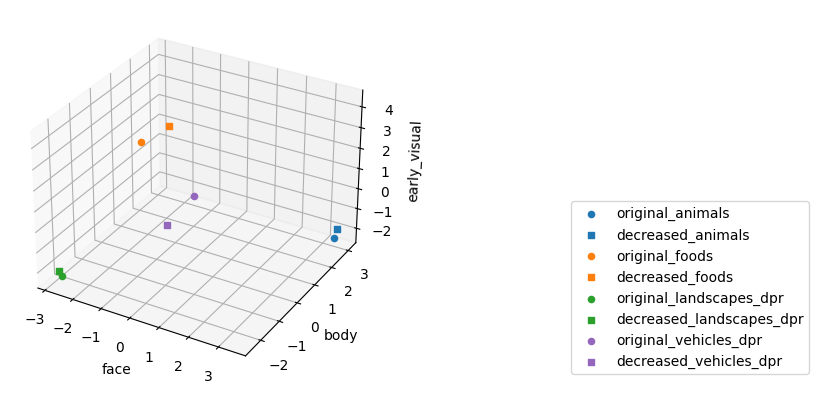

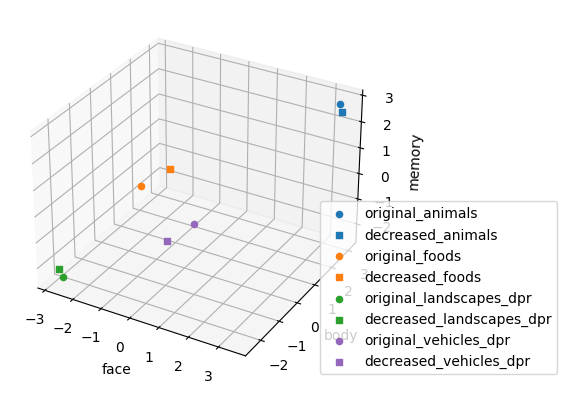

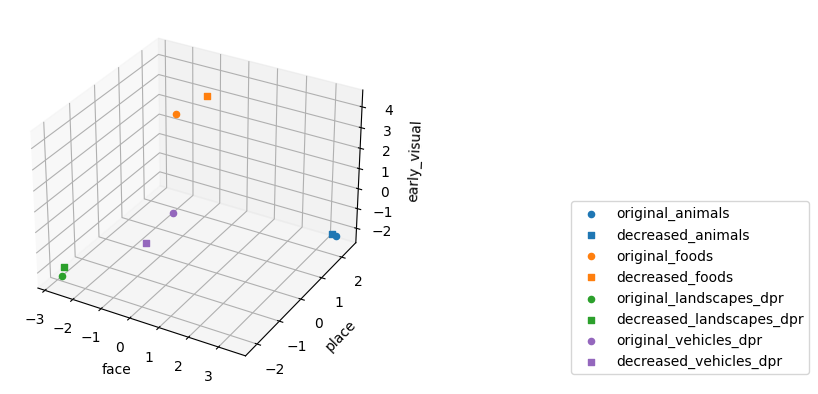

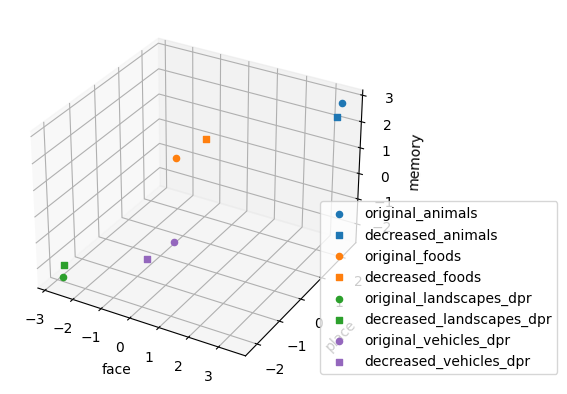

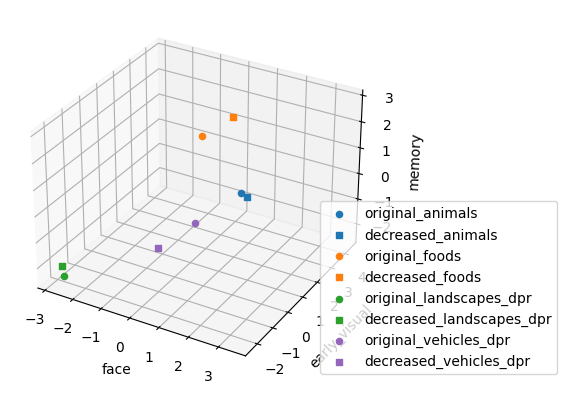

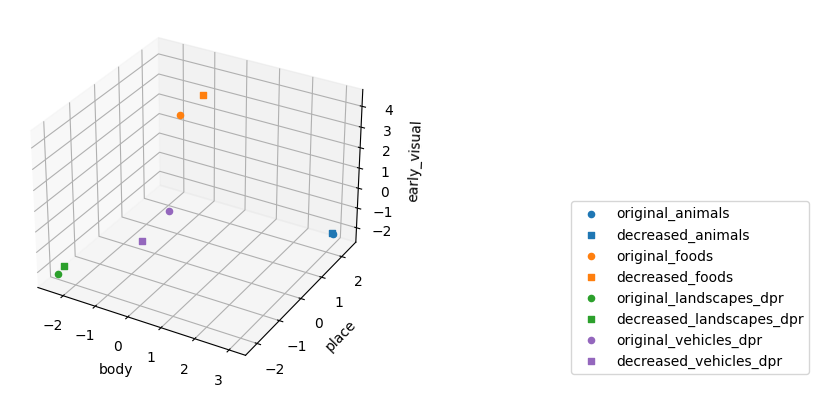

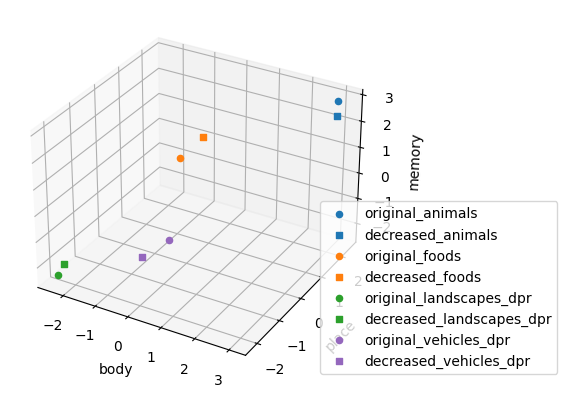

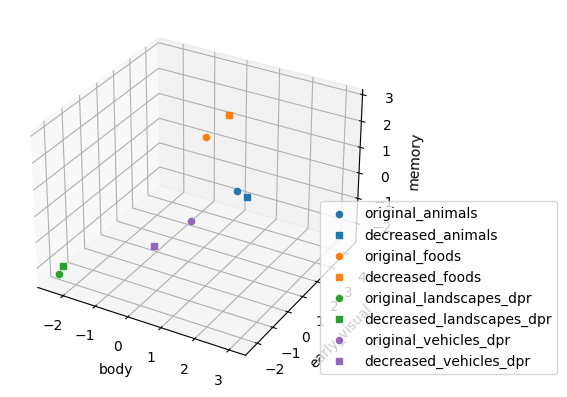

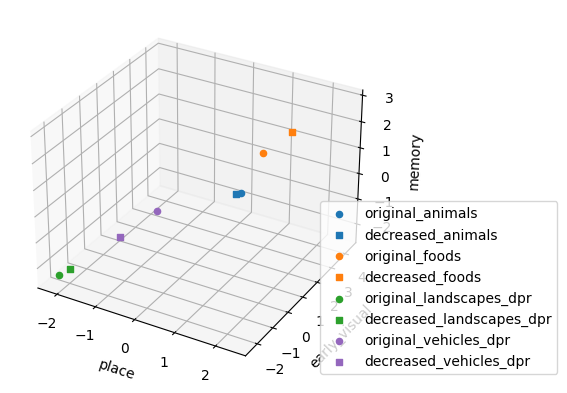

In [27]:
comb = combinations(list(range(len(ROIs_pca))), 3)

# for idx0, idx1, idx2 in comb:
#     fig = plt.figure()
#     ax = fig.add_subplot(projection='3d')

#     for idx, c in zip(list(range(4)), ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']):
#         ax.scatter(
#             pred_pca[idx][:, idx0], pred_pca[idx][:, idx1], pred_pca[idx][:, idx2],
#             color=c, label=f"original_{categories[idx]}", marker='o'
#         )
#         ax.scatter(
#             pred_l_pca[idx][:, idx0], pred_l_pca[idx][:, idx1], pred_l_pca[idx][:, idx2],
#             color=c, label=f"decreased_{categories[idx]}", marker='s'
#         )
    
#     ax.set_xlabel(ROIs_pca[idx0])
#     ax.set_ylabel(ROIs_pca[idx1])
#     ax.set_zlabel(ROIs_pca[idx2])

#     plt.legend(bbox_to_anchor=(1.5, 0.5))
#     plt.show()

for idx0, idx1, idx2 in comb:
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    for idx, c in zip(list(range(4)), ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']):
        ax.scatter(
            pred_pca[idx,idx0], pred_pca[idx,idx1], pred_pca[idx,idx2],
            color=c, label=f"original_{categories[idx]}", marker='o'
        )
        ax.scatter(
            pred_l_pca[idx,idx0], pred_l_pca[idx,idx1], pred_l_pca[idx,idx2],
            color=c, label=f"decreased_{categories[idx]}", marker='s'
        )
    
    ax.set_xlabel(ROIs_pca[idx0])
    ax.set_ylabel(ROIs_pca[idx1])
    ax.set_zlabel(ROIs_pca[idx2])

    plt.legend(bbox_to_anchor=(1.5, 0.5))
    plt.show()